In [1]:
# Supress Warning and import used libs
import warnings
import datetime
import matplotlib.pyplot as plt
import numpy as np
import gc
import folium
import folium.plugins as plugins

from utils.utils import (
        lat_lon_to_epsg,
        three_band_image,
        load_config_extents,
        transform_to_wgs)

warnings.filterwarnings('ignore')

In [2]:
# Import data loader

from utils.data_cube_utilities.loader import load_data
from utils.data_cube_utilities.loader import progress_cbk

In [3]:
# Define available spectral indices

def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

def MNDWI(dataset):
    return (dataset.green - dataset.swir2)/(dataset.green + dataset.swir2)

In [4]:
# Define available mosaic creation functions

def median_mosaic(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
    return create_median_mosaic(dataset)

def mean_mosaic(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_mean_mosaic
    return create_mean_mosaic(dataset)

def max_ndvi(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
    return create_max_ndvi_mosaic(dataset)

def most_recent(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_mosaic
    return create_mosaic(dataset)

In [5]:
# Comparative plotter that plots two images, a baseline and an analysis image.

def plotter(baseline, analysis):
    from utils.utils import three_band_image
    from matplotlib import pyplot as plt

    baseline_img = three_band_image(baseline, bands=['red', 'green', 'blue'])
    analysis_img = three_band_image(analysis, bands=['red', 'green', 'blue'])
    fig = plt.figure(1, [10, 20])

    plt.subplot(211)
    ax = plt.gca()
    ax.set_title("Baseline", fontweight='bold', fontsize=16)
    ax.set_xticklabels(baseline.x.values)
    ax.set_yticklabels(baseline.y.values)
    ax.set_xlabel('Easting', fontweight='bold')
    ax.set_ylabel('Northing', fontweight='bold')

    plt.imshow(baseline_img)

    plt.subplot(212)
    ax = plt.gca()
    ax.set_title("Analysis", fontweight='bold', fontsize=16)
    ax.set_xticklabels(analysis.x.values)
    ax.set_yticklabels(analysis.y.values)
    ax.set_xlabel('Easting', fontweight='bold')
    ax.set_ylabel('Northing', fontweight='bold')
    plt.imshow(analysis_img)

In [6]:
# Parameter checking & Input validation

def check_params(latitude, longitude, time_extents_b, time_extents_a, mosaic_type, spectral):
    if any(lat < -90 or lat > 90 for lat in latitude) or any(lon < -180 or lon > 180 for lon in longitude):
        raise ValueError("Invalid latitude or longitude.")

    time_extents_b = (datetime.datetime.strptime(time_extents_b[0], "%Y-%m-%d"),
                    datetime.datetime.strptime(time_extents_b[1], "%Y-%m-%d"))

    if time_extents_b[0] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for baseline.")
    if time_extents_b[1] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for baseline.")
    if time_extents_b[0] > time_extents_b[1]:
        raise ValueError("Invalid time extents for baseline.")

    time_extents_a = (datetime.datetime.strptime(time_extents_a[0], "%Y-%m-%d"),
                    datetime.datetime.strptime(time_extents_a[1], "%Y-%m-%d"))

    if time_extents_a[0] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for analysis.")
    if time_extents_a[1] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for analysis.")
    if time_extents_a[0] > time_extents_a[1]:
        raise ValueError("Invalid time extents for analysis.")

    if mosaic_type not in ["median", "mean", "maxndvi", "recent"]:
        raise ValueError("Invalid mosaic type.")

    if spectral not in ["ndwi", "mndwi"]:
        raise ValueError("Invalid spectral index.")

### latitude: List of two float numbers represeting the latitude extents. Ex [45.10, 45.25]

### latitude: List of two float numbers represeting the longitude extents. Ex [22.10, 22.25]

### time_extents_b: Tuple of two strings representing the time extents for the baseline.
    Ex ('2013-05-01', '2013-12-01')

### time_extents_a: Tuple of two strings representing the time extents for the analysis period.
    Ex ('2019-05-01', '2019-12-01')

### mosaic_type: String representing the type of mosaic that should be used when creating a cloud-free image.
    This should be one of:
        - "median"
        - "mean"
        - "maxndvi"
        - "recent"

### spectral: String representing the spectral index that should be used to analyze the DOI.
    This can be one of:
        - "ndwi"
        - "mndwi"
                
### max_cloud: Float representing the maximum percentage of clouded pixels.

In [7]:
# You can change the DOI and algorithm settings here

latitude = [45.24,45.10]
longitude = [29.63,29.84]
time_extents_b = ("2013-05-01","2013-12-01")
time_extents_a = ("2019-05-01","2019-12-01")
mosaic_type = "median"
spectral = "ndwi"
max_cloud = 0.05

In [8]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

In [9]:
try:
    check_params(latitude, longitude, time_extents_b, time_extents_a, mosaic_type, spectral)
except ValueError as e:
    print(e.__str__())

product = "ls8_usgs_level1_scene"
platform = "LANDSAT_8"
EPSG = lat_lon_to_epsg(latitude[1], longitude[1])
output_crs = 'EPSG:' + EPSG
resolution = (-30, 30)

In [10]:
# Load the data
time_extents = time_extents_a
analysis = load_data(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    progress_cbk=progress_cbk,
    max_cloud=max_cloud,
    measurements=(
        'red',
        'blue',
        'green',
        'nir',
        'swir2',
        'quality'
    )
)

time_extents = time_extents_b
baseline = load_data(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    progress_cbk=progress_cbk,
    max_cloud=max_cloud,
    measurements=(
        'red',
        'blue',
        'green',
        'nir',
        'swir2',
        'quality'
    )
)


([2019, 5, 1], [2019, 6, 1])


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


([2019, 6, 1], [2019, 7, 1])
Cloud coverage is under 0.05%, stopping early.
([2013, 5, 1], [2013, 6, 1])
Cloud coverage is under 0.05%, stopping early.


In [11]:
# Mask creating  & Pixel Filtering
from datacube.storage import masking  # Import masking capabilities

# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask_baseline = masking.make_mask(
    baseline.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion=False)

masked_cloud_baseline = baseline.where((baseline != 0) & clean_pixel_mask_baseline)

# We don't need the original datasets now, we only need the masked datasets, so we can free some memory.
# Delaying this step may result in OOM errors.
del(baseline)
gc.collect()

# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask_analysis = masking.make_mask(
    analysis.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion=False)

masked_cloud_analysis = analysis.where((analysis != 0) & clean_pixel_mask_analysis)

# We don't need the original datasets now, we only need the masked datasets, so we can free some memory.
# Delaying this step may result in OOM errors.
del(analysis)
gc.collect()

0

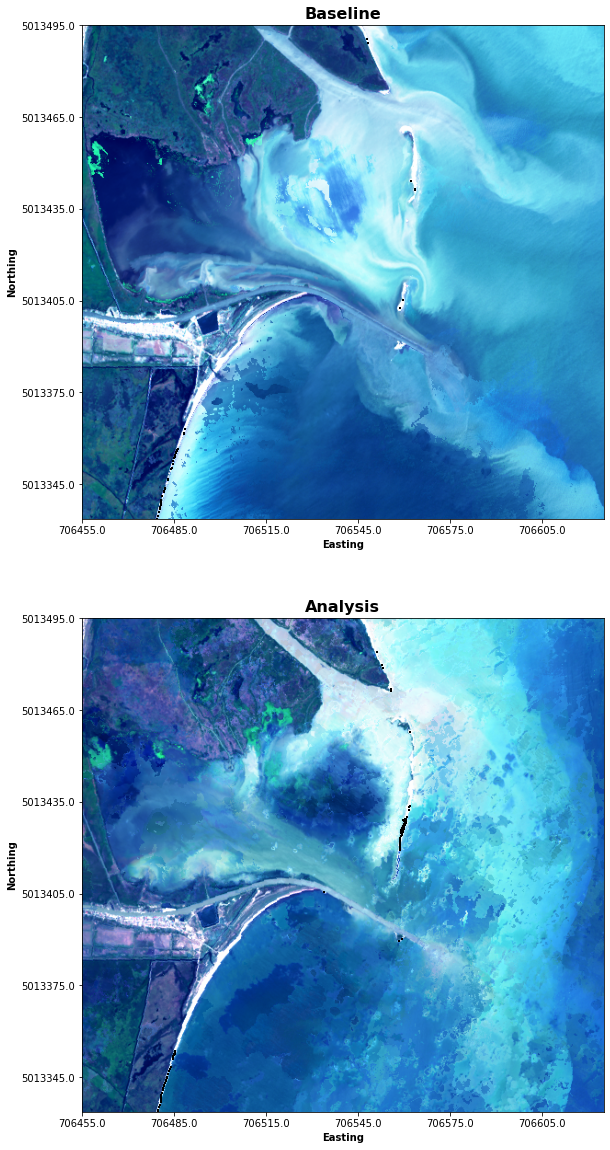

In [12]:
# Mosaic Creation
mosaic = {"median": median_mosaic, "mean": mean_mosaic, "maxndvi": max_ndvi, "recent": most_recent}
baseline_mosaic = mosaic[mosaic_type](masked_cloud_baseline)
analysis_mosaic = mosaic[mosaic_type](masked_cloud_analysis)

baseline_mosaic = baseline_mosaic.expand_dims({"time":1})
analysis_mosaic = analysis_mosaic.expand_dims({"time":1})

plotter(baseline_mosaic, analysis_mosaic)


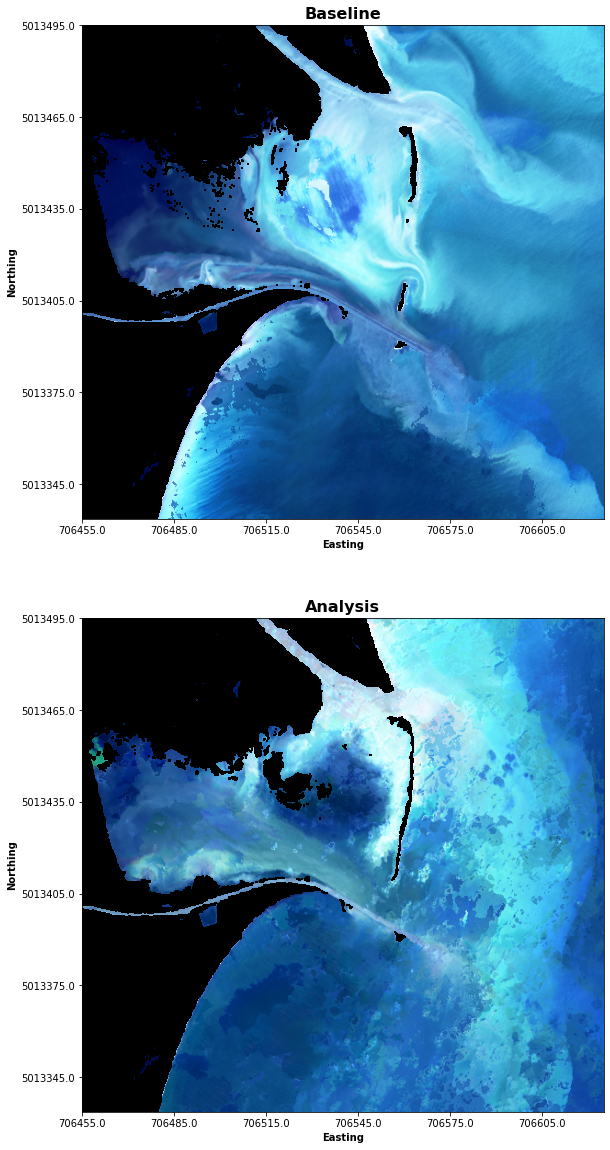

In [13]:
# Compute spectral indices
index = {"ndwi": NDWI, "mndwi": MNDWI}
baseline_index = baseline_mosaic.where(index[spectral](baseline_mosaic) > 0.01)
analysis_index = analysis_mosaic.where(index[spectral](analysis_mosaic) > 0.01)

plotter(baseline_index, analysis_index)

In [14]:
baseline_index = (baseline_index.fillna(np.max(baseline_index) + 1))
baseline_index = baseline_index.where(baseline_index >= np.max(baseline_index))
baseline_index = baseline_index.fillna(0)

analysis_index = (analysis_index.fillna(np.max(analysis_index) + 1))
analysis_index = analysis_index.where(analysis_index >= np.max(analysis_index))
analysis_index = analysis_index.fillna(0)

# Define the vertical filter
vertical_filter = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

# Define the horizontal filter
horizontal_filter = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]


t = baseline_index.dims.get("time")
rows = baseline_index.dims.get("y")
cols = baseline_index.dims.get("x")

baseline_index_red = baseline_index.red.values
baseline_index_red[baseline_index_red > 0] = 1

analysis_index_red = analysis_index.red.values
analysis_index_red[analysis_index_red > 0] = 1

edges_img_baseline = baseline_index_red.copy()
edges_img_analysis = analysis_index_red.copy()

for time in range(t):
    for row in range(3, rows - 2):
        for col in range(3, cols - 2):
            local_pixels_red_baseline = baseline_index_red[time, row - 1:row + 2, col - 1:col + 2]
            local_pixels_red_analysis = analysis_index_red[time, row - 1:row + 2, col - 1:col + 2]

            vertical_transformed_baseline = vertical_filter * local_pixels_red_baseline
            vertical_transformed_analysis = vertical_filter * local_pixels_red_analysis

            vertical_score_baseline = vertical_transformed_baseline.sum() / 4
            vertical_score_analysis = vertical_transformed_analysis.sum() / 4

            horizontal_transformed_baseline = horizontal_filter * local_pixels_red_baseline
            horizontal_transformed_analysis = horizontal_filter * local_pixels_red_analysis

            horizontal_score_baseline = horizontal_transformed_baseline.sum() / 4
            horizontal_score_analysis = horizontal_transformed_analysis.sum() / 4

            edge_score_baseline = (vertical_score_baseline ** 2 + horizontal_score_baseline ** 2) ** .5
            edge_score_analysis = (vertical_score_analysis ** 2 + horizontal_score_analysis ** 2) ** .5

            edges_img_baseline[time, row, col] = edge_score_baseline * 3
            edges_img_analysis[time, row, col] = edge_score_analysis * 3

edges_img_baseline = edges_img_baseline/edges_img_baseline.max()
edges_img_analysis = edges_img_analysis/edges_img_analysis.max()

edges_img_baseline[edges_img_baseline > 0] = 1
edges_img_analysis[edges_img_analysis > 0] = 1

masked_baseline = np.ma.masked_where(edges_img_baseline < 0.5, edges_img_baseline)
masked_analysis = np.ma.masked_where(edges_img_analysis < 0.5, edges_img_analysis)

t, h, w = masked_baseline.shape
data_baseline = np.zeros((h, w, 4), dtype=np.uint8)
data_baseline[:, :] = [0, 0, 0, 255]
data_baseline[:, :, 0] = masked_baseline[0] * np.random.randint(150, 255, 1)
data_baseline[:, :, 1] = masked_baseline[0] * np.random.randint(0, 255, 1)
data_baseline[:, :, 2] = masked_baseline[0] * np.random.randint(0, 255, 1)
data_baseline[:, :, 3] = ~masked_baseline[0].mask * 255

t, h, w = masked_analysis.shape
data_analysis = np.zeros((h, w, 4), dtype=np.uint8)
data_analysis[:, :] = [0, 0, 0, 255]
data_analysis[:, :, 0] = masked_analysis[0] * np.random.randint(150, 255, 1)
data_analysis[:, :, 1] = masked_analysis[0] * np.random.randint(0, 255, 1)
data_analysis[:, :, 2] = masked_analysis[0] * np.random.randint(0, 255, 1)
data_analysis[:, :, 3] = ~masked_analysis[0].mask * 255


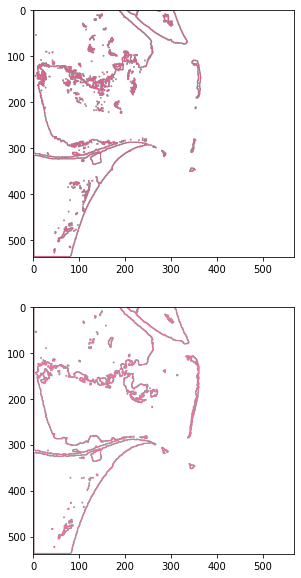

In [15]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(data_baseline)
plt.subplot(212)
plt.imshow(data_analysis)

In [16]:
from utils.data_cube_utilities.dc_display_map import display_map
folium_map = display_map(latitude = latitude, longitude = longitude)
computed_images = [
    {"img":(three_band_image(baseline_mosaic, bands=["red","green","blue"])*255).astype(int), "name": "Baseline Mosaic"},
    {"img":(three_band_image(analysis_mosaic, bands=["red","green","blue"])*255).astype(int), "name": "Analysis Mosaic"},
    {"img":data_baseline, "name":"Baseline"},
    {"img":data_analysis, "name": "Analysis"}
]
bounds=[[latitude[0], longitude[0]], [latitude[1], longitude[1]]]

for image in computed_images:
    folium.raster_layers.ImageOverlay(image=image.get("img"), bounds=bounds, name=image.get("name")).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
                                      

In [17]:
folium_map